# Resume Text Classifiaction

In this notebook, I present my solution for the task of German text classification from resumes.

In [1]:
# import all needed packages
from data_io import read_json_data, store_datasets_as_csv
from preprocessing import tokenize, downsample, train_dev_test_split
from flair_resume_text_classifier import FlairResumeTextClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import random
import numpy as np
import argparse

# fix the random seeds, for reproducibility.
random.seed(1)
np.random.seed(1)

In [2]:
# Fix the data and output path. Change these if you have different folder structure
data_path = 'data/'
output_path = 'output/'

## 1. Read Raw Json data

In [3]:
dataframe_raw = read_json_data(data_path)

Parsed json file:  10249 rows.


## 2. Pre-analysis
Check if classes are balanced. If not, this introduces bias. Several approaches exist but I chose to downsample the dominant classes.

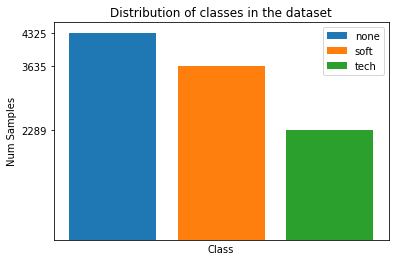

In [4]:
labels_count = dataframe_raw['label'].value_counts().to_dict()
for i, (label, count) in enumerate(labels_count.items()):
    plt.bar(i+1, count, label=label)
plt.yticks(list(labels_count.values()))
plt.ylabel('Num Samples')
plt.xticks([])
plt.xlabel('Class')
plt.title('Distribution of classes in the dataset')
plt.legend()
plt.show()

Data is indeed imbanaced. So we will need to downsample the none and soft classes to 2289 samples each.

## 3. Preprocessing

### 3.1 Downsampling

In [5]:
dataframe_downsampled = downsample(dataframe_raw, column_name='label')

### 3.2 Tokenization
Here I use a simple word tokenizer that doesn't remove any special characters. My proposal is that special characters are strong indications for the none class, i.e. they are relevant.

In [6]:
tokenize(dataframe_downsampled)

### 3.3 Train - Dev - Test  Split
Train is 60%, Dev and Test are 20% each.

In [7]:
train, dev, test = train_dev_test_split(dataframe_downsampled, column_name='label', dev_test_percentage=0.4)

_________

Now that data is ready for Flair, store it as CSV files in the data output (because flair doesn't work with dataframes)

In [9]:
store_datasets_as_csv(train, dev, test, data_path)

## 4. Initialize Flair Objects
Use the wrapper class to initialize the required flair objects: embeddings, corpus, classifier and model trainer.
Note that you need a GPU for the model to finish in a reasonable time

At this step, all embeddings will be downloaded, but only for the first time. Size is roughly 1.3 GB.

In [10]:
column_map = {k: v for k, v in enumerate(dataframe_downsampled.columns)}
model = FlairResumeTextClassifier(data_path, column_map, output_path, 'gpu')

2020-03-29 10:55:30,747 Reading data from data
2020-03-29 10:55:30,748 Train: data\train.csv
2020-03-29 10:55:30,749 Dev: data\dev.csv
2020-03-29 10:55:30,750 Test: data\test.csv
2020-03-29 10:55:32,516 Computing label dictionary. Progress:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4120/4120 [00:00<00:00, 69742.84it/s]

2020-03-29 10:55:32,579 [b'soft', b'tech', b'none']
Initializing word embeddings from FastText and Flair


## 5. Train the model
Model runs only for 20 epochs.

Note I don't train the model because I wrote the notebook on a weak machine. However, this took around 5 minutes on a cluster machine with NVIDIA GTX Titan X.

Also this step is output-heavy

In [ ]:
model.train()

## 6. Prediction and Error Analysis
Predict the samples output on train, dev and test. Calculate the accuracy and show the confusion matrix between classes.

In [ ]:
train_predictions, dev_predictions, test_predictions = model.get_train_dev_test_predictions(train, dev, test)

train_acc = accuracy_score(train['label'], train_predictions['prediction'])
dev_acc = accuracy_score(dev['label'], dev_predictions['prediction'])
test_acc = accuracy_score(test['label'], test_predictions['prediction'])

print('Accuracy: Train:', train_acc, 'Dev:', dev_acc, 'Test:', test_acc)

Pretty good accuracy given how fast and relatively simple the model is

In [ ]:
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(dev['label'], dev_predictions, labels=['none', 'soft', 'tech']),
                   columns=['none', 'soft', 'tech'], index=['none', 'soft', 'tech']))


### That's it. I hope you enjoyed reading this. Please have a look at the code, I made sure it is as readable and documented as possible.